# Phase curve model overview

**Author:** *Hannu Parviainen*<br>
**Last edited:** *28.8.2022*

The full TESS phase curve model consists of four separate components

- thermal emission
- reflected light
- ellipsoidal variations
- Doppler beaming

The first two, reflected light and thermal emission, originate from the planet, so they are multiplied by an eclipse model that tells the fraction of the planet's disk visible to the observer (that is, it takes values from one to zero.) The second two, ellipsoidal variations and Doppler boosting, originate from the star, and are multiplied by a transit model.

The observed flux is

$$F = \frac{T \times \left(1 + f_\mathrm{EV} + f_\mathrm{DB} \right) + E \times (f_\mathrm{R} + f_\mathrm{E})}{f_0}$$

where $f_0$ is the baseline flux level, $T$ is the transit model, $f_\mathrm{EV}$ is the ellipsoidal variation component, $f_\mathrm{DB}$ is the Doppler boosting component, $E$ is the eclipse model, $f_\mathrm{R}$ is the reflected flux, and $f_\mathrm{E}$ is the thermal emission.


In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
%run core.py

In [3]:
from pytransit import QuadraticModel, EclipseModel
from pytransit.models.numba.phasecurves import (lambert_phase_function, emission, ev_and_db,
                                                ellipsoidal_variation, doppler_boosting)
from src.kelt1 import AAOCW

In [4]:
zero_epoch = 0.0  # Zero epoch
period = 1.2      # Orbital period [d]
aor = 4.0         # Semi-major axis divided by the stellar radius
ror = 0.1         # Planet to star radius ratio

time = zero_epoch + linspace(-0.8*period, 0.8*period, 500)

em = EclipseModel()
tm = QuadraticModel(interpolate=False)
em.set_data(time)
tm.set_data(time)

## Reflected flux

We model the reflected flux using Lambertian phase function. The planet to star flux ratio is now

$$
F_\mathrm{R} = a_\mathrm{g} \frac{k^2}{a^2} \frac{\sin\alpha + (\pi - \alpha) \cos\alpha}{\pi}
$$

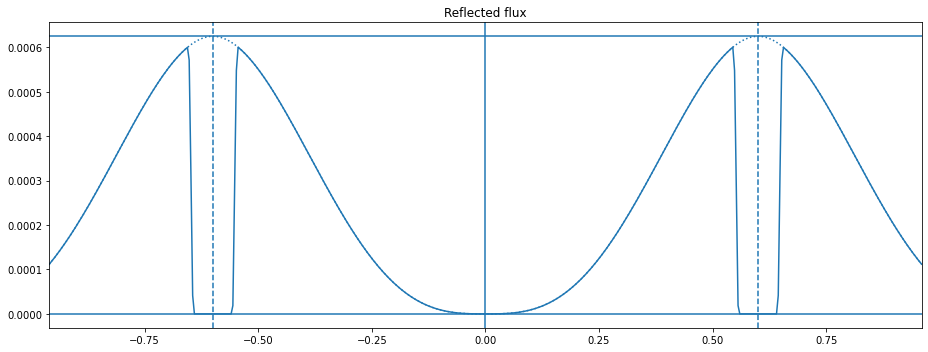

In [5]:
fr = squeeze(lambert_phase_function(aor, ror**2, 1.0, zero_epoch, period, x_is_time=True, x=time))
fe = em.evaluate(ror, zero_epoch, period, aor, 0.5*pi, multiplicative=True)

fig, ax = subplots(figsize=(13,5))
ax.plot(time, fr*fe)
ax.plot(time, fr, ':', c='C0')
ax.axvline(zero_epoch)
ax.axvline(zero_epoch - 0.5*period, ls='--')
ax.axvline(zero_epoch + 0.5*period, ls='--')
ax.axhline(0.0, ls='-')
ax.axhline(ror**2/aor**2, ls='-')
setp(ax, title='Reflected flux', xlim=time[[0,-1]])
fig.tight_layout()

## Thermal emission

We model the thermal emission as a sine wave between the night-side flux ratio and day side flux ratio.

$$
F_\mathrm{E} = k^2 \left( f_\mathrm{n} + 0.5 (f_\mathrm{d} - f_\mathrm{n})(1-\cos(f + o)) \right)
$$

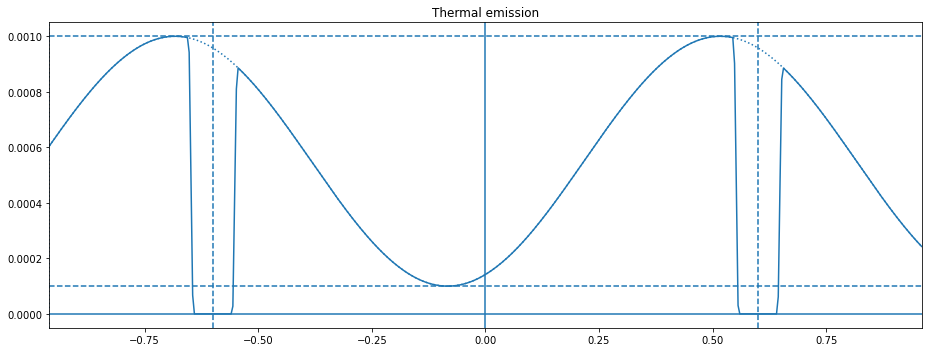

In [6]:
frn, frd = 0.01, 0.1
ft = squeeze(emission(ror**2, frn, frd, radians(25), zero_epoch, period, x_is_time=True, x=time))
fe = em.evaluate(ror, zero_epoch, period, aor, 0.5*pi, multiplicative=True)

fig, ax = subplots(figsize=(13,5))
ax.plot(time, ft*fe)
ax.plot(time, ft, ':', c='C0')
ax.axvline(zero_epoch)
ax.axvline(zero_epoch-0.5*period, ls='--')
ax.axvline(zero_epoch+0.5*period, ls='--')
ax.axhline(0.0, ls='-')
ax.axhline(ror**2*frn, ls='--')
ax.axhline(ror**2*frd, ls='--')
ax.axvline(time[argmax(f)], ls=':')
setp(ax, title='Thermal emission', xlim=time[[0,-1]])
fig.tight_layout()

## Ellipsoidal variation

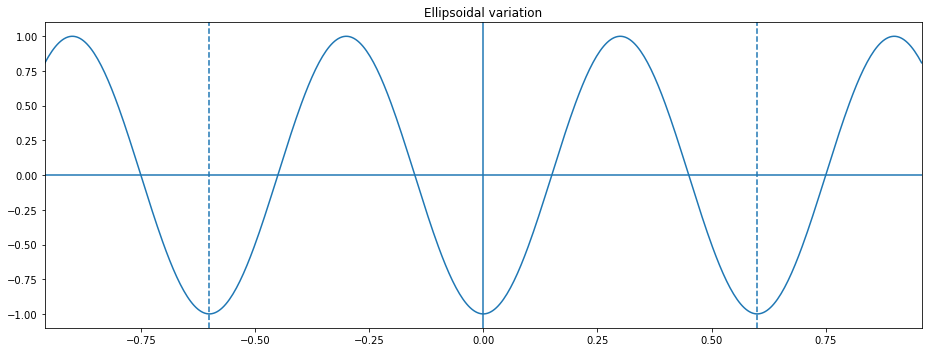

In [7]:
fig, ax = subplots(figsize=(13,5))
f =  squeeze(ellipsoidal_variation(1.0, zero_epoch, period, 0.0, x_is_time=True, x=time))
ax.plot(time, f)
ax.axvline(zero_epoch)
ax.axvline(zero_epoch - 0.5*period, ls='--')
ax.axvline(zero_epoch + 0.5*period, ls='--')
ax.axhline(0.0, ls='-')
setp(ax, title='Ellipsoidal variation', ylim=(-1.1, 1.1), xlim=time[[0,-1]])
fig.tight_layout()

## Doppler Beaming

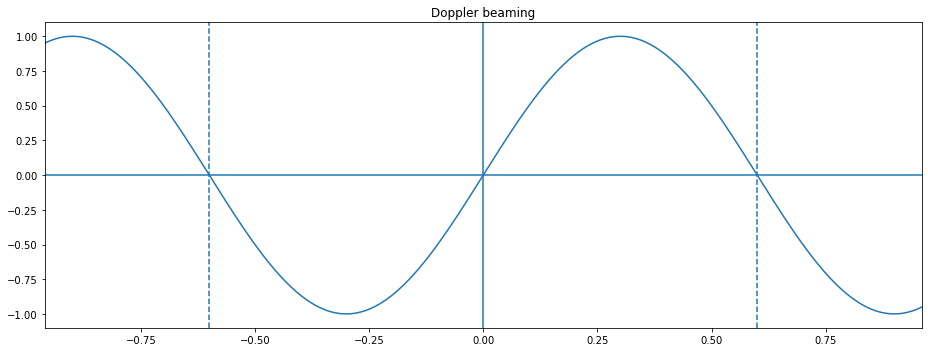

In [8]:
fig, ax = subplots(figsize=(13,5))
f =  squeeze(doppler_boosting(1.0, zero_epoch, period, x_is_time=True, x=time))
ax.plot(time, f)
ax.axvline(zero_epoch)
ax.axvline(zero_epoch-0.5*period, ls='--')
ax.axvline(zero_epoch+0.5*period, ls='--')
ax.axhline(0.0, ls='-')
setp(ax, title='Doppler beaming', ylim=(-1.1, 1.1), xlim=time[[0,-1]])
fig.tight_layout()

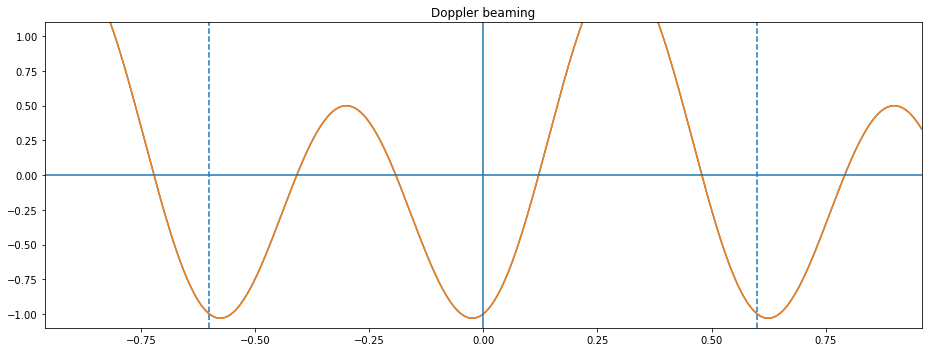

In [9]:
fig, ax = subplots(figsize=(13,5))
f1 =  squeeze(ellipsoidal_variation(1.0, zero_epoch, period, 0.0, x_is_time=True, x=time))
f2 =  squeeze(doppler_boosting(0.5, zero_epoch, period, x_is_time=True, x=time))
f3 =  squeeze(ev_and_db(1.0, 0.5, zero_epoch, period, 0.0, x_is_time=True, x=time))
ax.plot(time, f1+f2)
ax.plot(time, f3)
ax.axvline(zero_epoch)
ax.axvline(zero_epoch-0.5*period, ls='--')
ax.axvline(zero_epoch+0.5*period, ls='--')
ax.axhline(0.0, ls='-')
setp(ax, title='Doppler beaming', ylim=(-1.1, 1.1), xlim=time[[0,-1]])
fig.tight_layout()

In [10]:
em = EclipseModel()
tm = QuadraticModel(interpolate=False)

period = 1.0

time = zero_epoch + linspace(-0.1, period+0.1, 500)

em.set_data(time)
tm.set_data(time)

sma = 4.0
aev = 5e-4
adb = 5e-4
frn, frd = 0.03, 0.08

fem = squeeze(emission(ror**2, frn, frd, radians(45), zero_epoch, period, x_is_time=True, x=time))
fre = squeeze(lambert_phase_function(aor, ror**2, 1.0, zero_epoch, period, x_is_time=True, x=time))
ftr = tm.evaluate(ror, [0.2, 0.1], zero_epoch, period, sma, 0.5*pi)
fec = em.evaluate(ror, zero_epoch, period, aor, 0.5*pi, multiplicative=True)
fev = squeeze(ellipsoidal_variation(aev, zero_epoch, period, 0.0, x_is_time=True, x=time))
fdb = squeeze(doppler_boosting(adb, zero_epoch, period, x_is_time=True, x=time))

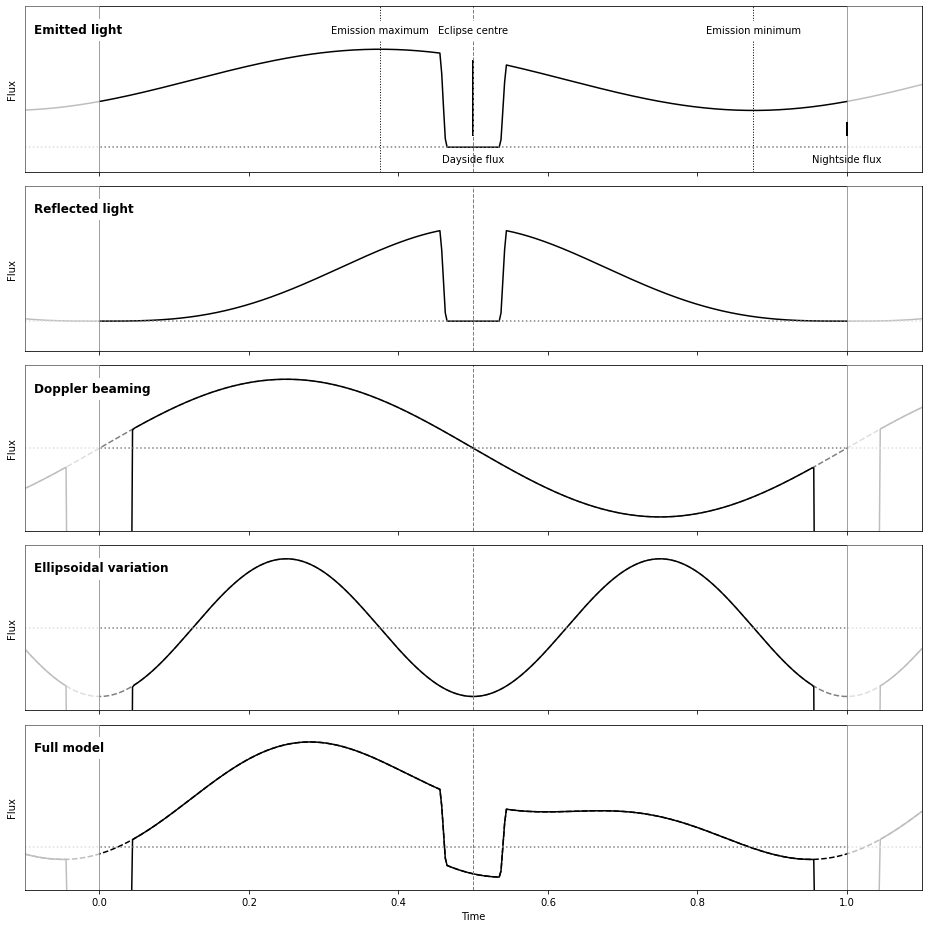

In [26]:
fig, axs = subplots(5, 1, figsize=(13,13), sharex='all')

t_eclipse_center = period / 2

# Emission
# --------
t_emission_peak = t_eclipse_center - 45 / 360 * period
t_emission_bottom = t_emission_peak + 0.5*period
f_emission_peak = ror**2 * frd
f_emission_bottom = ror**2 * frn

axs[0].plot(time, 1 + fec*fem, 'k')
axs[0].axvline(t_emission_peak, c='k', lw=1, ls=':')
axs[0].axvline(t_emission_bottom, c='k', lw=1, ls=':')
axs[0].axhline(1.0, c='0.5', ls=':')
axs[0].text(0.01, 0.9, 'Emitted light', va='top', transform=axs[0].transAxes, weight='bold', 
            size='large', zorder=15, backgroundcolor='w')
axs[0].text(0.5*period, 1.001, 'Eclipse centre', va='top', ha='center', backgroundcolor='w')
axs[0].text(t_emission_peak, 1.001, 'Emission maximum', va='top', ha='center', backgroundcolor='w')
axs[0].text(t_emission_bottom, 1.001, 'Emission minimum', va='top', ha='center', backgroundcolor='w')
axs[0].text(t_eclipse_center, 0.9999, 'Dayside flux', va='center', ha='center')
axs[0].text(period, 0.9999, 'Nightside flux', va='center', ha='center', zorder=100)
axs[0].plot([t_eclipse_center, t_eclipse_center], [1.0001, 1+f_emission_peak - 0.0001], 'k', lw=2)
axs[0].plot([period, period], [1.0001, 1+f_emission_bottom - 0.0001], 'k', lw=2, zorder=100)

# Reflected light
# ---------------
axs[1].plot(time, 1 + fec*fre, 'k')
axs[1].axhline(1.0, c='0.5', ls=':')
axs[1].text(0.01, 0.9, 'Reflected light', va='top', transform=axs[1].transAxes, weight='bold', 
            size='large', zorder=15, backgroundcolor='w')

# Doppler boosting
# ----------------
axs[2].plot(time, 1 + fdb, '--', c='0.5')
axs[2].plot(time, ftr + fdb, 'k')
axs[2].axhline(1.0, c='0.5', ls=':')
axs[2].text(0.01, 0.9, 'Doppler beaming', va='top', transform=axs[2].transAxes, weight='bold', 
            size='large', zorder=15, backgroundcolor='w')

# Ellipsoidal variation
# ---------------------
axs[3].plot(time, 1 + fev, '--', c='0.5')
axs[3].plot(time, ftr + fev, 'k')
axs[3].axhline(1.0, c='0.5', ls=':')
axs[3].text(0.01, 0.9, 'Ellipsoidal variation', va='top', transform=axs[3].transAxes, weight='bold', 
            size='large', zorder=15, backgroundcolor='w')


# All combined
# ------------
axs[4].plot(time, fec * (fem + fre) + (1 + fdb + fev), ls='--', c='k')
axs[4].plot(time, fec * (fem + fre) + ftr * (1 + fdb + fev), c='k')
axs[4].axhline(1.0, c='0.5', ls=':')
axs[4].text(0.01, 0.9, 'Full model', va='top', transform=axs[4].transAxes, weight='bold', 
            size='large', zorder=15, backgroundcolor='w')

[ax.axvspan(time[0], 0.0, zorder=10, alpha=0.75, fc='w', ec='0.5') for ax in axs]
[ax.axvspan(period, time[-1], zorder=10, alpha=0.75, fc='w', ec='0.5') for ax in axs]

[ax.axvline(t_eclipse_center, c='0.5', ls='--', lw=1) for ax in axs]

setp(axs, xlim=time[[0,-1]], yticks=[], ylabel='Flux')

setp(axs[0], ylim=(0.9998, 1.00115))
setp(axs[1], ylim=(0.9998, 1.0009))

setp(axs[2:4], ylim=(1-1.2*aev, 1+1.2*aev))
setp(axs[4], ylim=(0.9992, 1.0023), xlim=time[[0,-1]], xlabel='Time')


fig.tight_layout()

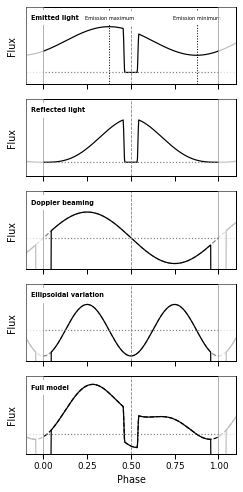

In [15]:
import seaborn as sb

stpars = dict(va='top', weight='bold', size=6.5, zorder=15, backgroundcolor='w')
atsize = 5
atpars = dict(size=atsize, backgroundcolor='w')

with sb.plotting_context('paper'):
    fig, axs = subplots(5, 1, figsize=(AAOCW, 2*AAOCW), sharex='all')

    t_eclipse_center = period / 2

    # Emission
    # --------
    t_emission_peak = t_eclipse_center - 45 / 360 * period
    t_emission_bottom = t_emission_peak + 0.5*period
    f_emission_peak = ror**2 * frd
    f_emission_bottom = ror**2 * frn

    axs[0].plot(time, 1 + fec*fem, 'k')
    axs[0].axvline(t_emission_peak, c='k', lw=1, ls=':')
    axs[0].axvline(t_emission_bottom, c='k', lw=1, ls=':')
    axs[0].axhline(1.0, c='0.5', ls=':')
    axs[0].text(0.024, 0.9, 'Emitted light', transform=axs[0].transAxes, **stpars)
    axs[0].text(t_emission_peak, 1.001, 'Emission maximum', va='top', ha='center', **atpars)
    axs[0].text(t_emission_bottom, 1.001, 'Emission minimum', va='top', ha='center', **atpars)

    # Reflected light
    # ---------------
    axs[1].plot(time, 1 + fec*fre, 'k')
    axs[1].axhline(1.0, c='0.5', ls=':')
    axs[1].text(0.024, 0.9, 'Reflected light', transform=axs[1].transAxes, **stpars)

    # Doppler boosting
    # ----------------
    axs[2].plot(time, 1 + fdb, '--', c='0.5')
    axs[2].plot(time, ftr + fdb, 'k')
    axs[2].axhline(1.0, c='0.5', ls=':')
    axs[2].text(0.024, 0.9, 'Doppler beaming', transform=axs[2].transAxes, **stpars)

    # Ellipsoidal variation
    # ---------------------
    axs[3].plot(time, 1 + fev, '--', c='0.5')
    axs[3].plot(time, ftr + fev, 'k')
    axs[3].axhline(1.0, c='0.5', ls=':')
    axs[3].text(0.024, 0.9, 'Ellipsoidal variation', transform=axs[3].transAxes, **stpars)


    # All combined
    # ------------
    axs[4].plot(time, fec * (fem + fre) + (1 + fdb + fev), ls='--', c='k')
    axs[4].plot(time, fec * (fem + fre) + ftr * (1 + fdb + fev), c='k')
    axs[4].axhline(1.0, c='0.5', ls=':')
    axs[4].text(0.024, 0.9, 'Full model', transform=axs[4].transAxes, **stpars)

    [ax.axvspan(time[0], 0.0, zorder=10, alpha=0.75, fc='w', ec='0.5') for ax in axs]
    [ax.axvspan(period, time[-1], zorder=10, alpha=0.75, fc='w', ec='0.5') for ax in axs]

    [ax.axvline(t_eclipse_center, c='0.5', ls='--', lw=0.8) for ax in axs]

    setp(axs, xlim=time[[0,-1]], yticks=[], ylabel='Flux')

    setp(axs[0], ylim=(0.9998, 1.00115))
    setp(axs[1], ylim=(0.9998, 1.0009))

    setp(axs[2:4], ylim=(1-1.2*aev, 1+1.8*aev))
    setp(axs[4], ylim=(0.9992, 1.0023), xlim=time[[0,-1]], xlabel='Phase')

    fig.tight_layout()
    fig.savefig('plots/phase_model_components.pdf')

---

<center>&copy 2022 Hannu Parviainen</center>